# Data Wrangling of Santander Cycles Open Data

For the analysis, I have used the Open Data for the Santander Cycles bike share scheme in London.
Here, I have done some data manipulation from the data that I acquired from Transport for London Open Data.

For this challenge, I did not use the real-time data from the API, but focused on the locations for bike points and some journeys data.

## Fetching the Bike Points

The data for bike points can be found from the [TfL Unified API](https://api.tfl.gov.uk/bikepoint).
I have converted this file into a GeoJSON file for analysis.

The data directory is not pushed to GitHub.
Downloads the raw data into `DL_path`, and saves the points assigned by `points_path`.

In [54]:
import os
import json
import urllib.request

import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.merge
from rasterio.plot import show
import matplotlib.pyplot as plt

In [3]:
# Converts Bike Points into GeoJSON file
# set paths
DL_path = "data/cycles/DL_data"
points_path = "data/cycles/points"
points_fn = "BikePoints.geojson"

In [ ]:
# import json file from TfL Unified API if not already in local
source_url = "https://api.tfl.gov.uk/BikePoint"

if os.path.exists(os.path.join(DL_path, "BikePoint.json")):
    print("Loading file from local")
    docks = json.load(open(os.path.join(DL_path, "BikePoint.json")))
else:
    print(f"Download from {source_url}") 
    with urllib.request.urlopen(source_url) as source:
        docks = json.load(source)
    # save to local
    docks_DL_data = json.dumps(docks)
    # creates saving directory if does not exist
    if not os.path.exists(DL_path):
        os.makedirs(DL_path)
    # save json file
    with open(os.path.join(DL_path, "BikePoint.json"), "w") as f:
        f.write(docks_DL_data)

# create output file
output = {
    "type": "FeatureCollection",
    "features" : []
}

# add docks data
for d in docks:
    for x in d["additionalProperties"]:
        if x["key"] == "TerminalName":
            id = x["value"]
    lat = d["lat"]
    lon = d["lon"]
    long_name = d["commonName"]

    #Separate area and specific port name
    # comma = d["commonName"].rfind(",")
    # if comma != -1:
    #     loc = d["commonName"][:comma]
    #     area = d["commonName"][comma+1:]
    # else:
    #     loc = ""
    #     area = ""
        
    for x in d["additionalProperties"]:
        if x["key"] == "NbDocks":
            docks = x["value"]

    # GeoJSON features
    port = {
        "type": "Feature",
        "geometry": {
            "type": "Point",
            "coordinates": [lon, lat]
        },
        "properties": {
            "id": id,
            "name": long_name,
            # "location": loc,
            # "area": area,
            "ports": docks,
        },
    }
    output["features"].append(port)

# create output
docks_geojson = json.dumps(output)

# creates saving directory if does not exist
if not os.path.exists(points_path):
    os.makedirs(points_path)

# save json file
with open(os.path.join(points_path, points_fn), "w") as f:
    f.write(docks_geojson)
print("done")
    

## Create GeoDataFrame

In [4]:
# create geodataframe

points_gdf = gpd.read_file(os.path.join(points_path, points_fn))

# split location and zone
name = ['location', 'zone']
points_gdf[name] = points_gdf['name'].str.rsplit(pat = ',', n = 1, expand = True)

# clear spaces before and after commas
for n in name:
    points_gdf[n] = points_gdf[n].str.replace(r'^( +)|( +)$', r'', regex = True)

# fix zone name
replaces = {
    "Kings Cross": "King's Cross",
    "Parsons Green": "Parson's Green",
    "St Lukes": "St. Luke's",
    "St Pauls": "St. Paul's",
    "St.John's Wood": "St. John's Wood",
}
points_gdf['zone'] = points_gdf.zone.replace(replaces)

# convert into British National Grid
points_gdf = points_gdf.to_crs('EPSG:27700')

In [14]:
points_gdf.get_coordinates().y.describe()

count       800.000000
mean     180204.902844
std        2296.400357
min      174293.496179
25%      178738.606234
50%      180489.565605
75%      181931.978636
max      185252.061561
Name: y, dtype: float64

## Get raster data to extract location

In [28]:
# load data

# set the grid
grid = ['TQ27', 'TQ28', 'TQ37', 'TQ38']
subgrid = ['ne', 'nw', 'se', 'sw']

# set path
elev_path = [f'zip+file://data/elevation/lidar_composite_dtm-2022-2-{g}{s}.zip!/{g}{s}_DTM_2m.tif' for g in grid for s in subgrid]

In [46]:
# load raster data
src = []
for idx, path in enumerate(elev_path):
    src.append(rasterio.open(path))

In [67]:
merged, output = rasterio.merge.merge(src)

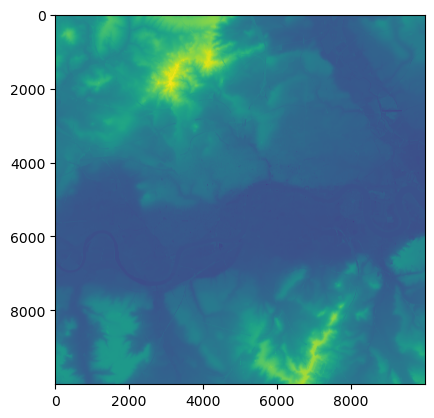

<Axes: >

In [68]:
show(merged)

In [70]:
out_meta = src[0].meta.copy()

out_meta.update(
    {
        "driver": "GTiff",
        "height": merged.shape[1],
        "width": merged.shape[2],
        "transform": output,
        "crs": "EPSG:27700"        
    }
)

In [71]:
with rasterio.open("data/elevation/london_elevation.tif", "w", **out_meta) as dest:
    dest.write(merged)

In [72]:
elevation = rasterio.open("data/elevation/london_elevation.tif")

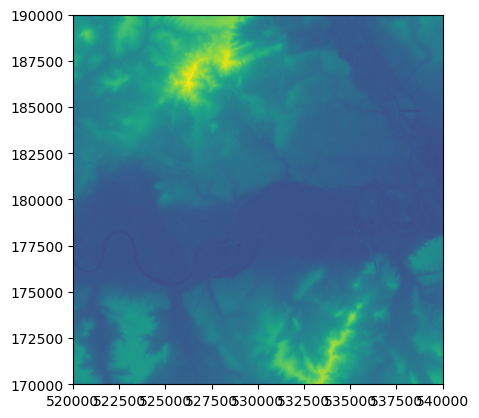

<Axes: >

In [74]:
show(elevation)

In [75]:
coords_list = [(x, y) for x, y in zip(points_gdf["geometry"].x, points_gdf["geometry"].y)]

In [82]:
points_gdf['height'] = [x[0] for x in elevation.sample(coords_list)]

In [83]:
points_gdf.height

0      32.264999
1      11.532250
2      16.526251
3      17.187750
4       5.821500
         ...    
795    14.308000
796     4.417750
797    17.792250
798    16.034500
799    25.077000
Name: height, Length: 800, dtype: float32